deuxième tentative

In [ ]:
!pip install keras_tuner
!wget -q https://raw.githubusercontent.com/Undeavor/PE28/main/CREDITAGRICOLESA_2025-10-15.txt -O CA2.txt

In [ ]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas_datareader import data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [ ]:
sp = pd.read_csv("/content/CA2.txt", sep="\t",usecols=["Date", "ouv", "haut", "bas", "Close", "vol", "devise"], parse_dates=["Date"], dayfirst=True )
print (sp.head())
print (sp.shape)

        Date     ouv    haut     bas   Close      vol devise
0 2005-10-17  23.078  23.172  22.899  23.040  2764750    EUR
1 2005-10-18  23.031  23.078  22.580  22.599  4425717    EUR
2 2005-10-19  22.467  22.608  22.223  22.241  4345454    EUR
3 2005-10-20  22.636  22.768  22.194  22.241  3568692    EUR
4 2005-10-21  22.091  22.420  22.091  22.138  2883072    EUR
(5119, 7)


In [ ]:
sp.Date = pd.to_datetime(sp.Date)
sp.dropna(inplace = True)
#on se limite au strict minimum de données pour l'instant : le prix de fermeture
sp.drop(columns = ["Date", "ouv", "haut", "bas", "vol", "devise"], inplace = True)
print (sp.head())
print (sp.shape)

    Close
0  23.040
1  22.599
2  22.241
3  22.241
4  22.138
(5119, 1)


    Close   returns  log_returns
1  22.599 -0.019141    -0.019326
2  22.241 -0.015841    -0.015968
3  22.241  0.000000     0.000000
4  22.138 -0.004631    -0.004642
5  22.617  0.021637     0.021406
(5118, 3)


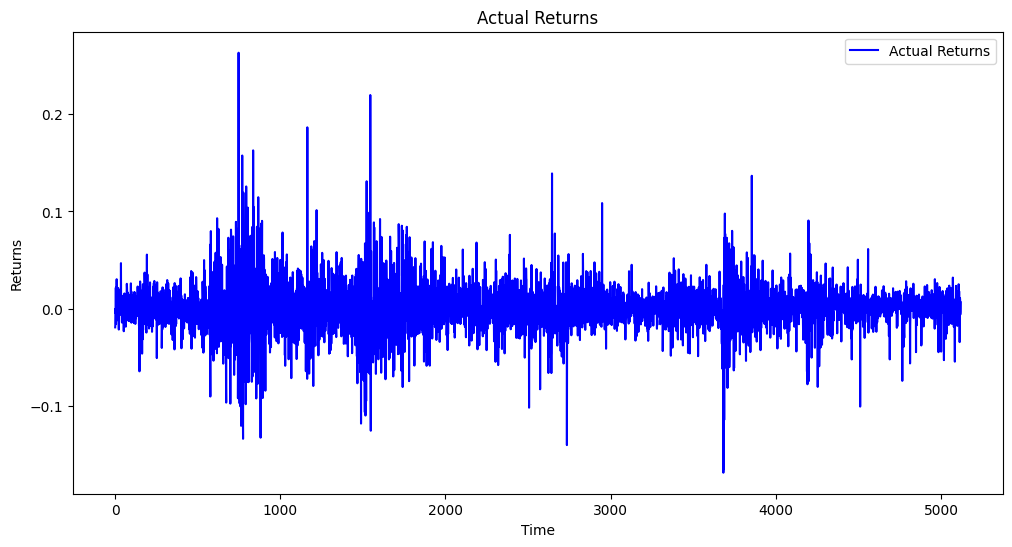

In [ ]:
sp['returns'] = sp['Close'].pct_change()
sp['log_returns'] = np.log(sp['Close'] / sp['Close'].shift(1))
sp.dropna(inplace = True)
print (sp.head())
print (sp.shape)
plt.figure(figsize=(12, 6))
plt.plot(sp.returns, label='Actual Returns', color='blue')
plt.title('Actual Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()

X_train = sp['returns']
#X = sp['log_returns'].values.reshape(-1, 1)
y_train = sp['returns']

In [ ]:
# -------------------------
# 1) LOSS = log-likelihood
# -------------------------
def gaussian_llh(y_true, outputs):

    mu = outputs[:, :1]        # AR(1)
    sigma_raw = outputs[:, 1:] # volatilité brute prédite par le MLP

    eps = 1e-8
    sigma = tf.nn.softplus(sigma_raw) + eps
    sigma2 = sigma**2

    return tf.reduce_mean(
        0.5 * tf.math.log(sigma2) +
        0.5 * tf.square(y_true - mu) / sigma2
    )

# -------------------------
# 2) Construction des inputs
# -------------------------
# X_train = returns(t-1)
# y_train = returns(t)

# On crée r(t-1)
X_ar1 = tf.concat([X_train[:1], X_train[:-1]], axis=0)

# -------------------------
# 3) MODELE KERAS
# -------------------------
input_rtm1 = Input(shape=(1,))  # r_{t-1}
input_rt   = Input(shape=(1,))  # r_t pour sigma

# ---- AR(1) branch ----
mu = Dense(1, use_bias=True)(input_rtm1)
# Dense(1) -> poids = a1, biais = a0

# ---- Volatility branch ----
x = Dense(128, activation='relu')(input_rt)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
sigma_raw = Dense(1)(x)

# ---- Merge outputs ----
output = Concatenate()([mu, sigma_raw])

model = Model(inputs=[input_rtm1, input_rt], outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=gaussian_llh
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │        256 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      8,256 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │      2,080 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │          2 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1)         │         33 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 2)         │          0 │ dense_6[0][0],    │
│ (Concatenate)       │                   │            │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,627 (41.51 KB)

 Trainable params: 10,627 (41.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
"""#hist = lstm.fit(X_train, y_train,batch_size=20,epochs=32,verbose=1,validation_split=0.3,shuffle=False)
hist = model.fit(
    X_train, y_train,         # données d'entraînement
    batch_size=80,            # nombre d'échantillons par mise à jour des poids
    epochs=32,                # nombre de passages sur tout le dataset
    verbose=0,                # 1 = affiche la progression
    #validation_split=0.3, #sert à qqch ??
    shuffle=False             # important pour les séries temporelles
)"""
hist = model.fit(
    [X_ar1, X_train],  # 2 inputs : r_{t-1}, r_t
    y_train,
    batch_size=80,
    epochs=32,
    verbose=1,
    shuffle=False
)

Epoch 1/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: -1.9140
Epoch 2/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -2.9821
Epoch 3/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -2.9204
Epoch 4/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -2.4281
Epoch 5/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -3.1301
Epoch 6/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -2.9874
Epoch 7/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -3.0415
Epoch 8/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -3.4704
Epoch 9/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -3.6728
Epoch 10/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -3.8350
Epoch 11/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -3.8442
Epoch 12/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: -3.8637
Epoch 13/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -3.9090
Epoch 14/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -3.8848
Epoch 15/32
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -3.9208
Epoc

In [ ]:
# Prédictions sur le test set
y_pred = model.predict([X_ar1, X_train])
mu_pred      = y_pred[:, 0]
sigma_raw    = y_pred[:, 1]
sigma_pred   = tf.nn.softplus(sigma_raw).numpy()

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


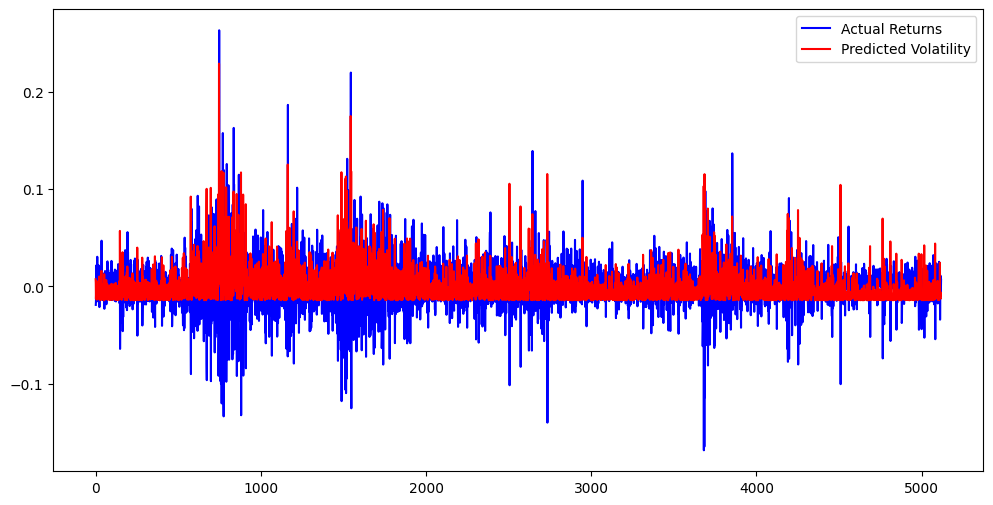

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Actual Returns', color='blue')
plt.plot((sigma_pred - sigma_pred.mean()),
         label='Predicted Volatility', color='red')
plt.legend()
plt.show()

<>:37: SyntaxWarning: invalid escape sequence '\s'
<>:37: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3214475556.py:37: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("Volatilité $\sigma_t$")


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006067. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


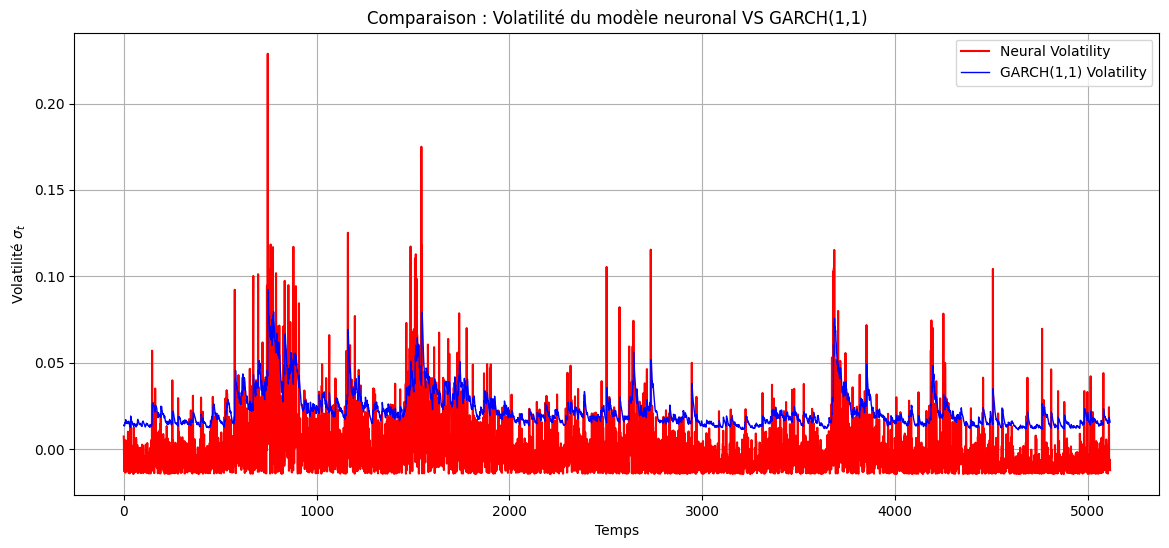

In [ ]:
!pip install arch
from arch import arch_model
import numpy as np
import matplotlib.pyplot as plt

#########################################
# 1. Estimation GARCH(1,1)
#########################################

am = arch_model(sp['returns'], mean='ARX',lags=1, vol='Garch', p=1, q=1, dist='normal')
res = am.fit(disp='off')

garch_vol = res.conditional_volatility.values  # σ_t du GARCH

#########################################
# 2. Remettre ton modèle neural en σ_t
#########################################

# ton modèle prédit sigma_raw → applique softplus si ce n'est pas déjà fait
sigma_nn = tf.nn.softplus(y_pred).numpy().flatten()

# tronquer à la même taille que GARCH si nécessaire :
min_len = min(len(sigma_nn), len(garch_vol))
sigma_nn = sigma_nn[:min_len]
garch_vol = garch_vol[:min_len]

#########################################
# 3. Tracé comparatif
#########################################

plt.figure(figsize=(14, 6))
plt.plot((sigma_pred - sigma_pred.mean()), label='Neural Volatility', color='red', linewidth=1.5)
plt.plot(garch_vol, label='GARCH(1,1) Volatility', color='blue', linewidth=1)

plt.title("Comparaison : Volatilité du modèle neuronal VS GARCH(1,1)")
plt.xlabel("Temps")
plt.ylabel("Volatilité $\sigma_t$")
plt.legend()
plt.grid(True)
plt.show()